In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2
%config IPCompleter.use_jedi = False

In [2]:
import pandas as pd
import numpy as np
from numpy import random as rnd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (20, 10)

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import (
    roc_auc_score, recall_score, precision_score, f1_score, accuracy_score
)
import os
from os import path
from operator import itemgetter
from itertools import chain, islice
from functools import reduce

In [3]:
RS = rnd.RandomState(rnd.MT19937(rnd.SeedSequence(42)))

In [4]:
!ls ../data/

appl.csv  balance.csv  com.csv	  dict_mcc.csv	payments.csv
aum.csv   client.csv   deals.csv  funnel.csv	trxn.csv


In [5]:
DATA = '../data'

DEALS = path.join(DATA, 'deals.csv')
TRANSACTIONS = path.join(DATA, 'trxn.csv')
CLIENTS = path.join(DATA, 'client.csv')
MCC_INFO = path.join(DATA, 'dict_mcc.csv')
AUM_INFO = path.join(DATA, 'aum.csv')
BALANCE_INFO = path.join(DATA, 'balance.csv')
CALL_INFO = path.join(DATA, 'appl.csv')
TARGET_INFO = path.join(DATA, 'funnel.csv')

In [6]:
target = pd.read_csv(TARGET_INFO, sep=',')

In [7]:
target.shape

(21498, 16)

In [8]:
target.head()

,client_id,sale_flg,sale_amount,contacts,feature_1,client_segment,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,region_cd
0,7513301859607023584,0,NaN,1,7,13.0,571533.0,15717.0,0.0,0.0,0.0,571852.0,472605.0,10.4,12548.0,86.0
1,9157009756404187626,0,NaN,1,3,13.0,3642369.0,94787.0,0.0,0.0,84823.0,3642369.0,3314257.0,8.9,77210.0,2.0
2,-1893104556496814867,0,NaN,1,5,16.0,352826.0,5500.0,0.0,6822.0,0.0,265893.0,204534.0,8.9,5508.0,52.0
3,6886062013213911831,0,NaN,1,4,3.0,6070615.0,40580.0,0.0,30401.0,0.0,2005731.0,1825051.0,7.9,40583.0,86.0
4,-8156468515495593794,1,138018.05,1,7,14.0,3642369.0,97156.0,81488.0,0.0,160308.0,3642369.0,3314257.0,10.4,78108.0,27.0


In [9]:
target.isna().sum(axis=0)

client_id             0
sale_flg              0
sale_amount       17979
contacts              0
feature_1             0
client_segment        0
feature_2             0
feature_3             0
feature_4             0
feature_5             0
feature_6             0
feature_7            11
feature_8            11
feature_9            11
feature_10           11
region_cd            34
dtype: int64

Информативность:

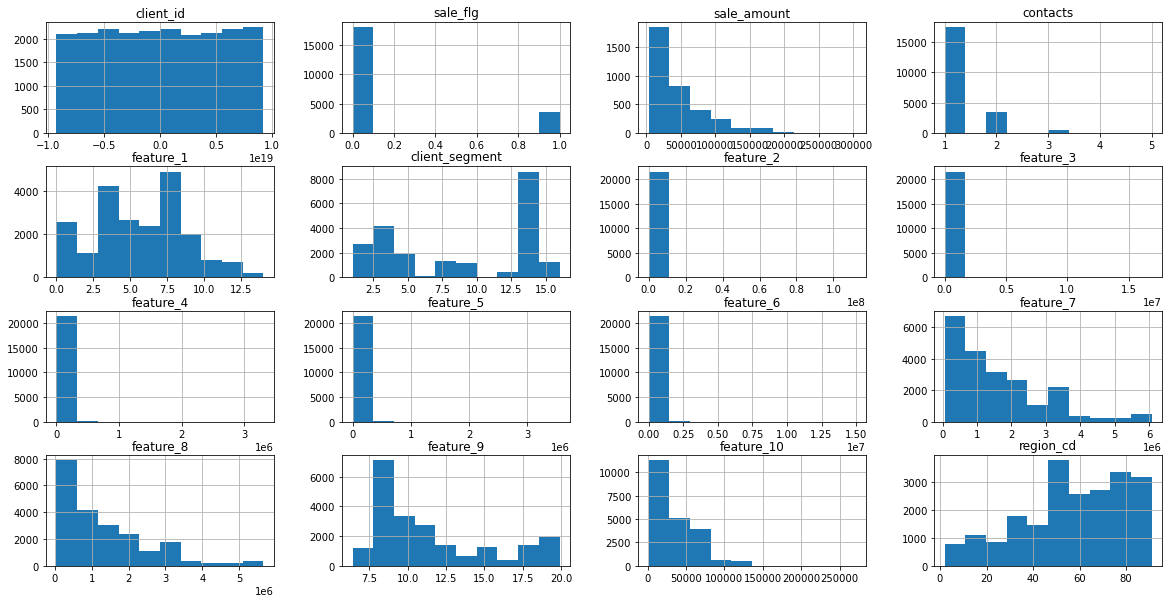

In [10]:
target.hist()
plt.show()

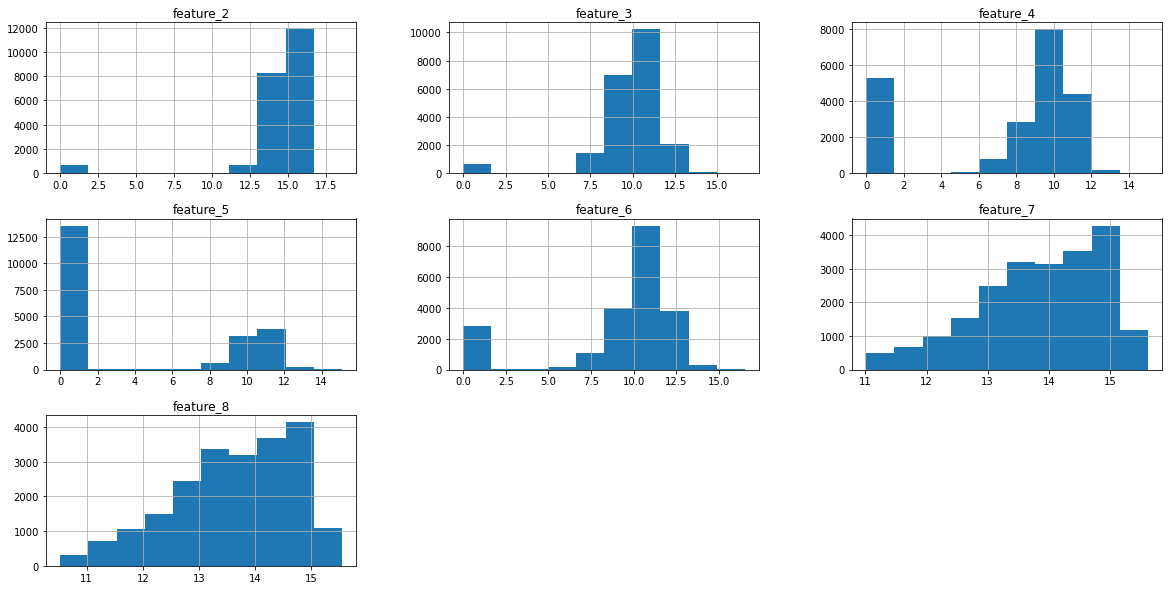

In [11]:
target[['feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8']].applymap(np.log1p).hist()
plt.show()

Let's add some categorical variables:

In [12]:
target['feature_5_0'] = target.feature_5 < 1e-10
target['feature_5_1'] = target.feature_5 > 1e-10

In [13]:
target['feature_4_0'] = target.feature_4 < 1e-10
target['feature_4_1'] = target.feature_4 > 1e-10

In [14]:
target.feature_7 = target.feature_7.fillna(target.feature_7.mode()[0])
target.feature_8 = target.feature_8.fillna(target.feature_8.mode()[0])
target.feature_9 = target.feature_9.fillna(target.feature_9.mode()[0])
target.feature_10 = target.feature_10.fillna(target.feature_10.mode()[0])

In [15]:
client = pd.read_csv(CLIENTS, sep=',')

In [16]:
client.head()

,client_id,gender,age,region,city,citizenship,education,job_type
0,7513301859607023584,F,33.0,0,115,RUSSIA,NaN,NaN
1,9157009756404187626,F,59.0,17,668,RUSSIA,NaN,NaN
2,-1893104556496814867,M,51.0,28,65,RUSSIA,NaN,NaN
3,6886062013213911831,F,56.0,0,40,RUSSIA,NaN,NaN
4,-8156468515495593794,F,34.0,-1,-1,RUSSIA,HIGHER_PROFESSIONAL,NaN


In [17]:
(client.city == -1).sum()

175

In [18]:
(client.region == -1).sum()

166

In [19]:
client.isna().sum(axis=0)

client_id          0
gender             3
age                3
region             0
city               0
citizenship        5
education      12218
job_type       21423
dtype: int64

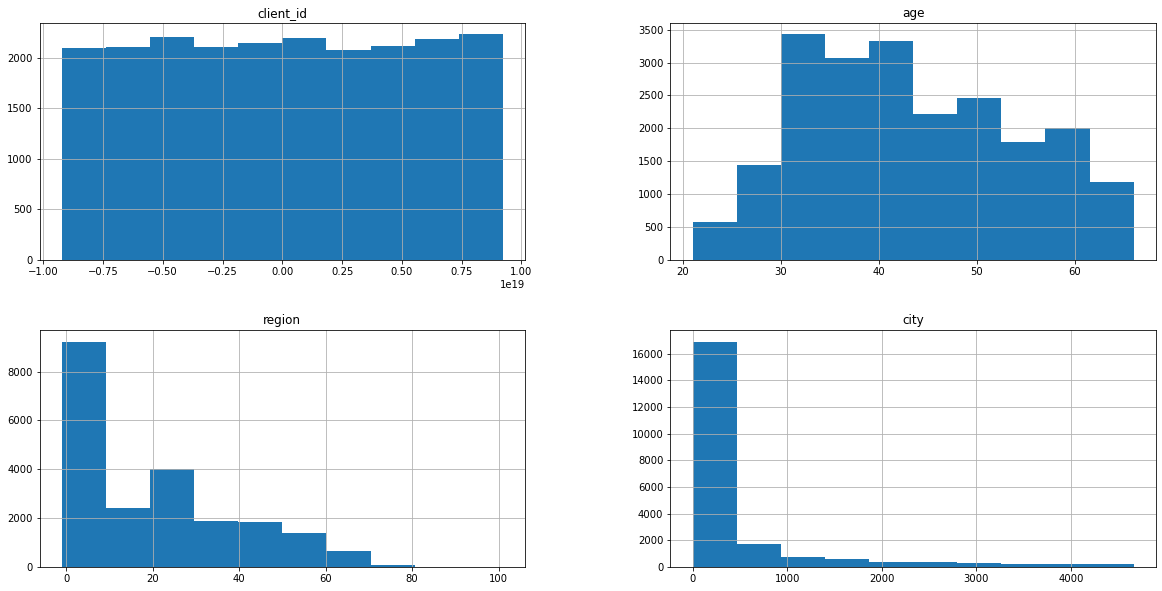

In [20]:
client.hist()
plt.show()

Let's drop this column for now:

In [21]:
client.job_type.value_counts(dropna=False)

NaN                21423
RETIRED               40
STUDENT               15
BUSINESS              15
MATERNITY_LEAVE        4
MILITARY               1
Name: job_type, dtype: int64

That's fine:

In [22]:
client.education.value_counts(dropna=False)

NaN                            12218
HIGHER_PROFESSIONAL             4463
MIDDLE_PROFESSIONAL             3550
FULL_GENERAL                     606
HIGHER_PROFESSIONAL_PARTIAL      258
PRIMARY_PROFESSIONAL             238
TWO_AND_MORE_HIGHER              147
SCHOLASTIC_DEGREE                 18
Name: education, dtype: int64

In [23]:
client.loc[client.education.isna(), 'education'] = 'MISSING'

In [24]:
client.citizenship.value_counts()

RUSSIA     21492
UKRAINE        1
Name: citizenship, dtype: int64

Glue together the rarest cities:

In [25]:
client.city[client.city > 1000].count()

2687

In [26]:
client.loc[(client.city > 1000) | (client.city == -1), 'city'] = 1001

Same for regions:

In [27]:
client.region[client.region > 60].count()

714

In [28]:
client.loc[(client.region > 60) | (client.region == -1), 'region'] = 61

In [29]:
client.gender.value_counts(dropna=False)

F      11116
M      10379
NaN        3
Name: gender, dtype: int64

Fill with the most common value:

In [30]:
client.gender = client.gender.fillna(value='F')

In [31]:
client.age = client.age.fillna(client.age.mode()[0])

In [32]:
client = pd.concat(
    [
        client.drop(['education', 'job_type', 'citizenship', 'region', 'city', 'gender'], axis=1), 
        pd.get_dummies(client.education, prefix='ED'),
        pd.get_dummies(client.region, prefix='REG'),
        pd.get_dummies(client.city, prefix='CIT'),
        pd.get_dummies(client.gender, prefix='GEN')
    ],
    axis=1
)

In [33]:
client.columns

Index(['client_id', 'age', 'ED_FULL_GENERAL', 'ED_HIGHER_PROFESSIONAL',
       'ED_HIGHER_PROFESSIONAL_PARTIAL', 'ED_MIDDLE_PROFESSIONAL',
       'ED_MISSING', 'ED_PRIMARY_PROFESSIONAL', 'ED_SCHOLASTIC_DEGREE',
       'ED_TWO_AND_MORE_HIGHER',
       ...
       'CIT_982', 'CIT_985', 'CIT_987', 'CIT_988', 'CIT_992', 'CIT_993',
       'CIT_995', 'CIT_1001', 'GEN_F', 'GEN_M'],
      dtype='object', length=819)

In [34]:
target = target.set_index('client_id')
client = client.set_index('client_id')

In [35]:
target.shape, client.shape

((21498, 19), (21498, 818))

No new columns added, yay!

In [36]:
pd_train = target.join(client)
pd_train.shape

(21498, 837)

In [37]:
folds = []
for i in range(5):
    with open(f'../folds/fold_{i}_train.txt', mode='r') as inp:
        tr = np.array([*map(int, inp)])
    with open(f'../folds/fold_{i}_test.txt', mode='r') as inp:
        te = np.array([*map(int, inp)])
    folds.append((tr, te))

In [38]:
pd_train.columns[pd_train.isna().sum(axis=0) > 0]

Index(['sale_amount', 'region_cd'], dtype='object')

In [39]:
y = pd_train.sale_flg.to_numpy()
earn = pd_train.sale_amount.fillna(0).to_numpy()
cont = pd_train.contacts.to_numpy()
X = pd_train.drop(['sale_flg', 'sale_amount', 'contacts', 'region_cd'], axis=1).to_numpy()

In [40]:
preds = []
labs = []

earnings = []
contacts_cnt = []

for train_idxs, test_idxs in folds:
    X_train = pd_train.loc[train_idxs] \
        .drop(['sale_flg', 'sale_amount', 'contacts', 'region_cd'], axis=1).to_numpy()
    y_train = pd_train.loc[train_idxs] \
        .sale_flg.to_numpy()

    
    X_test = pd_train.loc[test_idxs] \
        .drop(['sale_flg', 'sale_amount', 'contacts', 'region_cd'], axis=1).to_numpy()
    y_test = pd_train.loc[test_idxs] \
        .sale_flg.to_numpy()
    
    earn = pd_train.loc[test_idxs] \
        .sale_amount.fillna(0).to_numpy()
    cont = pd_train.loc[test_idxs] \
        .contacts.to_numpy()
    
    clf = RandomForestClassifier(
        n_estimators=1000, 
        criterion='entropy',
        min_samples_leaf=10,
        random_state=RS,
        max_samples=0.6
    ).fit(X_train, y_train)
    
    preds.append(clf.predict_proba(X_test)[:, 1])
    labs.append(y_test)
    earnings.append(earn)
    contacts_cnt.append(cont)

In [41]:
preds = np.hstack(preds)
labs = np.hstack(labs)
earnings = np.hstack(earnings)
contacts_cnt = np.hstack(contacts_cnt)

In [42]:
def metrics(labels, probs, earnings, contacts_cnt, p_thr=0.5):
    auc = roc_auc_score(labels, probs)
    
    pred_labs = probs > p_thr
    
    acc = accuracy_score(labels, pred_labs)
    rec = recall_score(labels, pred_labs)
    pre = precision_score(labels, pred_labs)
    f1 = f1_score(labels, pred_labs)
    target_metric = (pred_labs * earnings - 4000 * contacts_cnt).mean()
    
    return auc, acc, rec, pre, f1, target_metric

In [43]:
auc, acc, rec, pre, f1, trg = metrics(labs, preds, earnings, contacts_cnt, .03)

In [44]:
print(f'auc: {auc:4.3f}, acc: {acc:4.3f}, rec: {rec:4.3f}, pre: {pre:4.3f}, f1: {f1:4.3f}')

auc: 0.910, acc: 0.244, rec: 1.000, pre: 0.177, f1: 0.300


In [45]:
print(f'target: {trg:f}')

target: 2744.051710
